<a href="https://colab.research.google.com/github/Amana28/Deep-Learning/blob/master/PAC_Bounds_for_Axis_Aligned_Rectangles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Implement Learning

# File Upload

In [879]:
from google.colab import files      # for file upload
import os

# .csv file should be formatted as Name, Type ('+', '-') and the n Dimensions as separate columns

uploaded = files.upload()
file_name = list(uploaded.keys())[0]      # get the name of the uploaded file
print(file_name)

# os.remove(file_name)

Saving Points.csv to Points (19).csv
Points (19).csv


# Reading Data

In [880]:
import io
import pandas as pd

my_df = pd.read_csv(io.BytesIO(uploaded[file_name]))     # use io.BytesIO to create a buffer -- leaving original data unmodified
labels_df = my_df[['Type']].copy()
my_df = my_df.iloc[:, 2:]
print(my_df.head())
print(labels_df.head())

   d1  d2  d3
0   5  10   1
1   6  20   2
2   7  15   3
3   2   5   4
4   6   7   5
  Type
0    +
1    -
2    +
3    -
4    +


# Training Classifier

In [881]:
# bounds for n-dimensional box

def train_classifier(df, labels):

    positive_points = df[[i for i, label in enumerate(labels) if label == '+']]     # Filter for positive points
    if positive_points.size == 0:
        return 0, 0, 0
    # Initialize min and max coordinates for the box in every dimension
    min_coords = positive_points.min(axis=0)
    max_coords = positive_points.max(axis=0)

    length_coords = max_coords - min_coords     # for calculating the volume/area
    volume = np.prod(length_coords)

    return min_coords, max_coords, volume

In [882]:
import numpy as np

min_coords, max_coords, volume = train_classifier(my_df.values, labels_df.values)
print("min_coords: ", min_coords)
print("max_coords: ", max_coords)
print("volume: ", volume)

min_coords:  [1 1 1]
max_coords:  [ 7 15  5]
volume:  336


### Creating a Classifier Function

In [883]:
import numpy as np

def classify(point):
    # Check if the point is within the rectangle
    inside = np.all((point >= min_coords) & (point <= max_coords))
    return '+' if inside else '-'

In [884]:
point = pd.Series([6, 3, 4], index=['d1', 'd2', 'd3'])

classify(point)

'+'

# Part 2: Make Some Heatmaps

# 1.

In [885]:
# Plotting
def plot(n):
    plt.figure(figsize=(10, 8))
    plt.imshow(n, cmap= 'viridis', interpolation='nearest')
    plt.colorbar(label='Minimum n')
    plt.xlabel('ε (epsilon)')
    plt.ylabel('δ (delta)')
    plt.title('Heatmap of Minimum Sample Size n')

    # Set x-ticks with truncated labels (for truncating labels created by odd resolutions e.g: 0.17)
    plt.xticks(range(len(epsilon)), [f"{xtick:.2f}" for xtick in np.linspace(0.1, 0.9, len(epsilon))])
    plt.yticks(range(len(delta)), [f"{ytick:.2f}" for ytick in np.linspace(0.1, 0.9, len(delta))])

    plt.show()

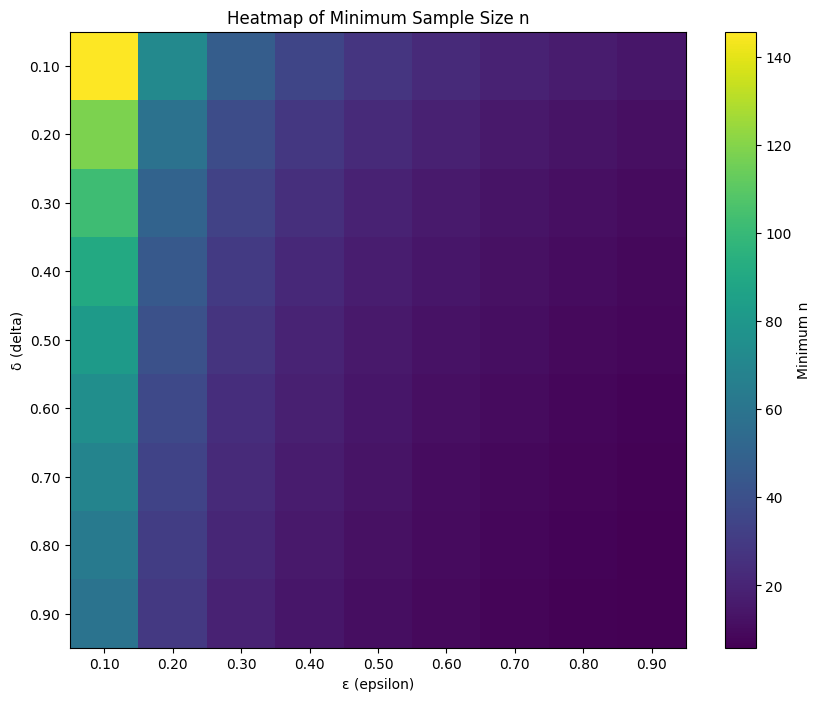

In [886]:
import matplotlib.pyplot as plt


# Desired resolution
resolution = 0.1

# Calculating the number of points for ε and δ based on the resolution
epsilon_num_points = int(((0.9 - 0.1) / resolution) + 1)
delta_num_points = int(((0.9 - 0.1) / resolution) + 1)

# Generate ε and δ with the specified resolution
epsilon = np.linspace(0.1, 0.9, epsilon_num_points)
delta = np.linspace(0.1, 0.9, delta_num_points)

# Everything else remains the same
E, D = np.meshgrid(epsilon, delta)      # Meshgrid for ε and δ
n = np.log(D / 4) / np.log(1 - (E / 4))     # Calculate the bound n ≥ (log(δ/4)/log(1 − ε/4))

plot(n)


# 2.

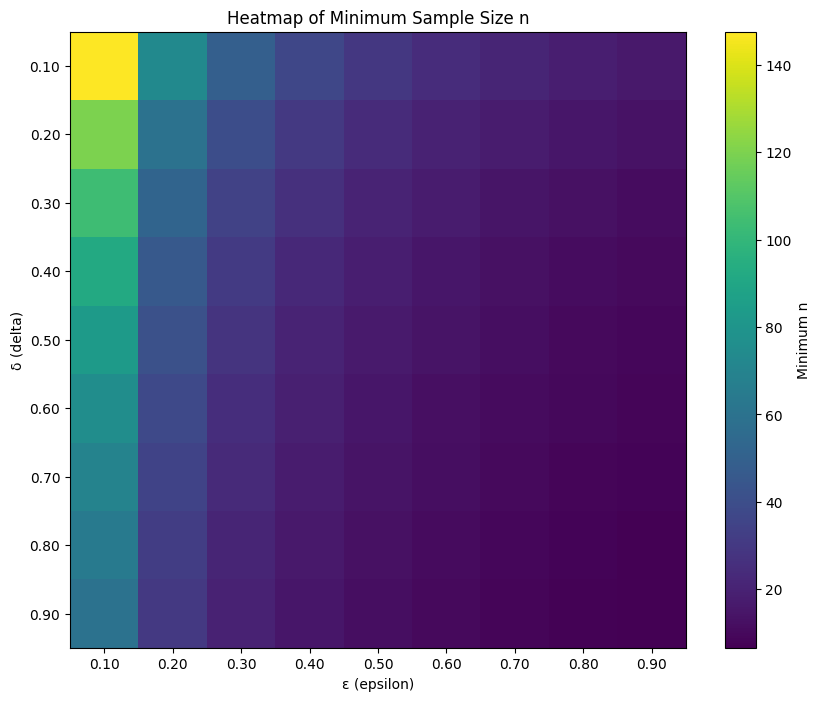

In [887]:
n_2 = 4/E * (np.log(4/D))  # Calculate the bound n ≥ 4/ε(log(4/δ))

plot(n_2)

# 3.

### Simulations

In [888]:
import math

"""
Iterate from n = 150 down to 1
For each n do T trials and compute the generalization error for each Trial (Area of F - Area of H)
For errors epsilon = 0.1 through 0.9 find the probability of being less than epsilon (1- delta)
Map n for the epsilon, delta coordinate
"""

T = 200

def simulate(x, y):
    # calulate the volume of our labeling function f (sqrt(2) ^ d)
    curr_d = x.shape[1]     # current dimension
    f_volume = math.pow(2 ** 0.5, curr_d)
    simulated_Ns = np.zeros((9, 9))

    for n in range(150, 2, -1):
        generalization_errors = []
        for t in range(1, T+1, 1):
            # sample n points and calculate the generalization error (f_volume - h_volume) for each h selected by our algorithm
            indices = np.random.choice(x.shape[0], size=n, replace=True)     # Generate random unique indices for iid sampling from x
            x_sampled = x[indices]
            y_sampled = y[indices]
            min_coords, max_coords, h_volume = train_classifier(x_sampled, y_sampled)
            generalization_error = (f_volume - h_volume)/f_volume
            generalization_errors.append(generalization_error)
        for e in epsilon:
            generalization_errors_array = np.array(generalization_errors)
            errors_under_e = np.sum(np.abs(generalization_errors_array) < e)
            d = 1 - (errors_under_e / T)
            e_rounded = np.rint(e * 10).astype(int) - 1  # Round and convert to int
            d_rounded = np.rint(d * 10).astype(int) - 1



            if 0 <= e_rounded <= 8 and 0 <= d_rounded <= 8:     # get rid of extreme values
                index = (d_rounded, e_rounded)
                simulated_Ns[index] = n
                # print(f"Probability of sampling a set with n = {n}, error greater than {e} is: {d}")

            # plot n for curr_epsilon and curr_delta on our heatmap
    return simulated_Ns

### Generating a distribution D from d dimensions

In [889]:
def muck_with_d(n_samples, d):

    x = np.random.uniform(-1, 1, (n_samples, d))

    boundary = 1 / (2 ** (1/d))   # Calculate the boundary condition

    y = label_within_hypercube(x, boundary)
    simulated_Ns = simulate(x, y)

    return simulated_Ns

In [890]:
def label_within_hypercube(x, boundary):

    d = x.shape[1]      # Get the number of dimensions
    conditions = []
    for i in range(d):
        conditions.append((x[:, i] >= -boundary) & (x[:, i] <= boundary))
    is_within = np.all(conditions, axis=0)      # Efficiently check all conditions together
    return np.where(is_within, '+', '-')

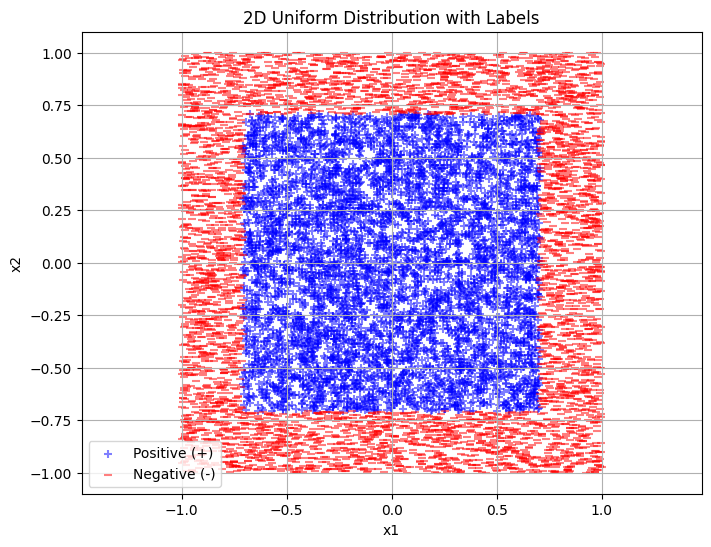

In [891]:
# Plotting Uniform Distribution for d = 2

x = np.random.uniform(-1, 1, (10000, 2))
boundary = 1 / (2 ** (1/2))   # Calculate the boundary condition

y = label_within_hypercube(x, boundary)

plt.figure(figsize=(8, 6))

# Filter and plot points labeled as '+'
positive_points = x[y == '+']
plt.scatter(positive_points[:, 0], positive_points[:, 1], c='blue', marker='+', label='Positive (+)', alpha=0.5)

# Filter and plot points labeled as '-'
negative_points = x[y == '-']
plt.scatter(negative_points[:, 0], negative_points[:, 1], c='red', marker='_', label='Negative (-)', alpha=0.5)

# Additional plot formatting
plt.title('2D Uniform Distribution with Labels')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()


In [892]:
# Plotting
def plot(simulated_Ns):
    plt.figure(figsize=(10, 8))
    plt.imshow(simulated_Ns, cmap= 'viridis', interpolation='nearest')
    plt.colorbar(label='Minimum n')
    plt.xlabel('ε (epsilon)')
    plt.ylabel('δ (delta)')
    plt.title('Heatmap of Minimum Sample Size n')

    # Set x-ticks with truncated labels (for truncating labels created by odd resolutions e.g: 0.17)
    plt.xticks(range(len(epsilon)), [f"{xtick:.2f}" for xtick in np.linspace(0.1, 0.9, len(epsilon))])
    plt.yticks(range(len(delta)), [f"{ytick:.2f}" for ytick in np.linspace(0.1, 0.9, len(delta))])

    plt.show()

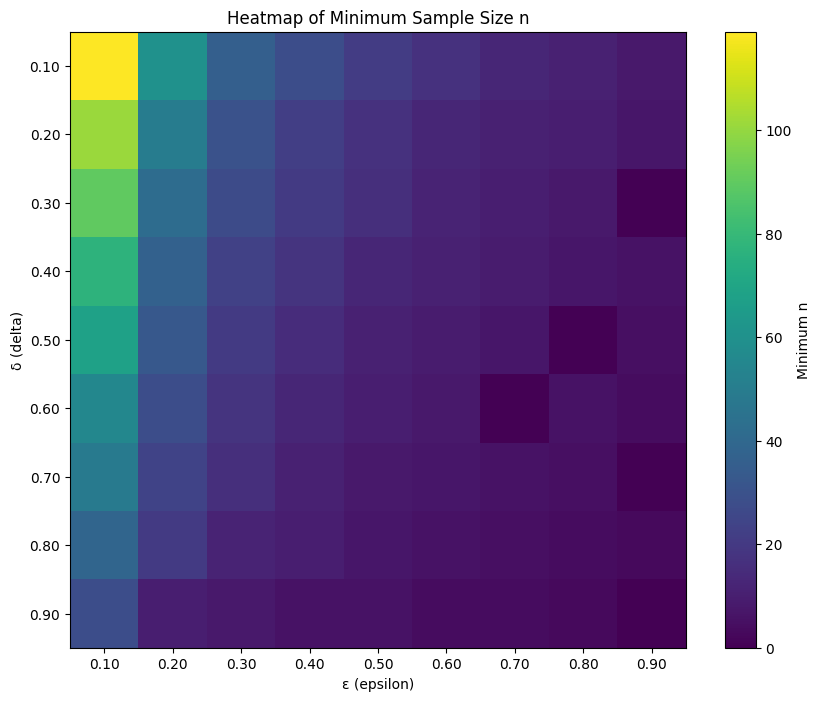

In [893]:
n_samples = 10000

n2 = muck_with_d(n_samples, 2)
plot(n2)

# Part 3: Muck With d

### d = 3

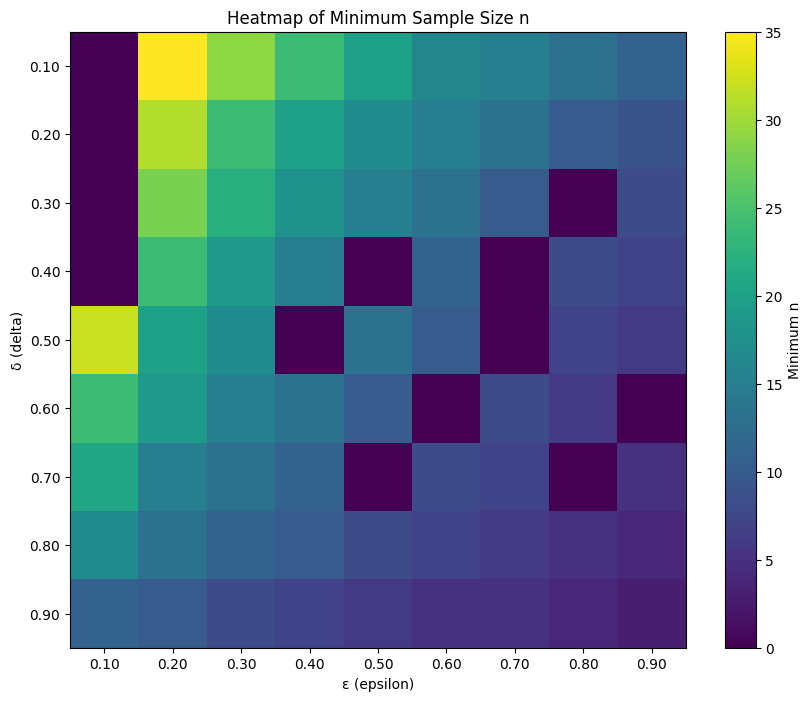

In [894]:
n3 = muck_with_d(n_samples, 3)
plot(n3)

## d = 4

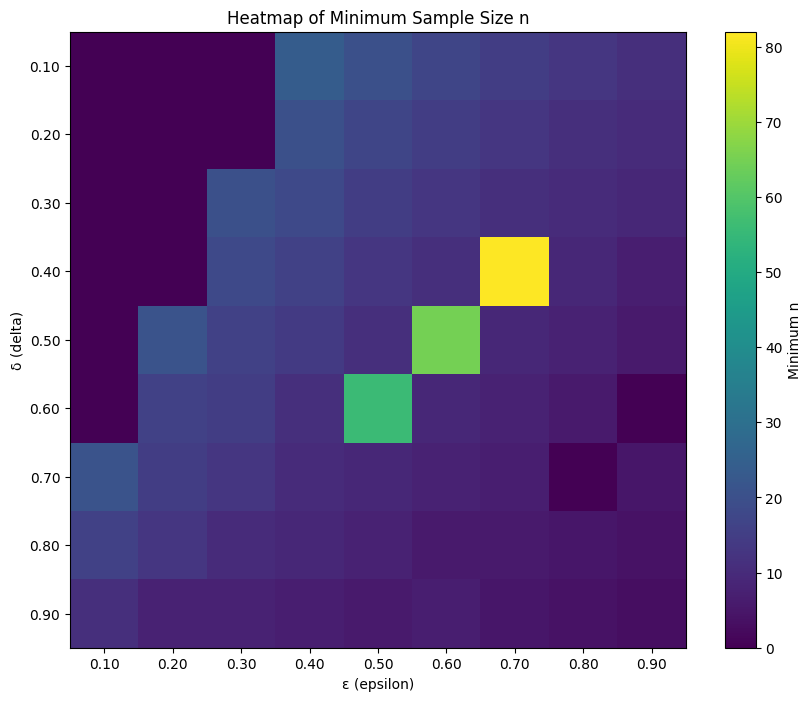

In [895]:
n4 = muck_with_d(n_samples, 4)
plot(n4)

## d = 5

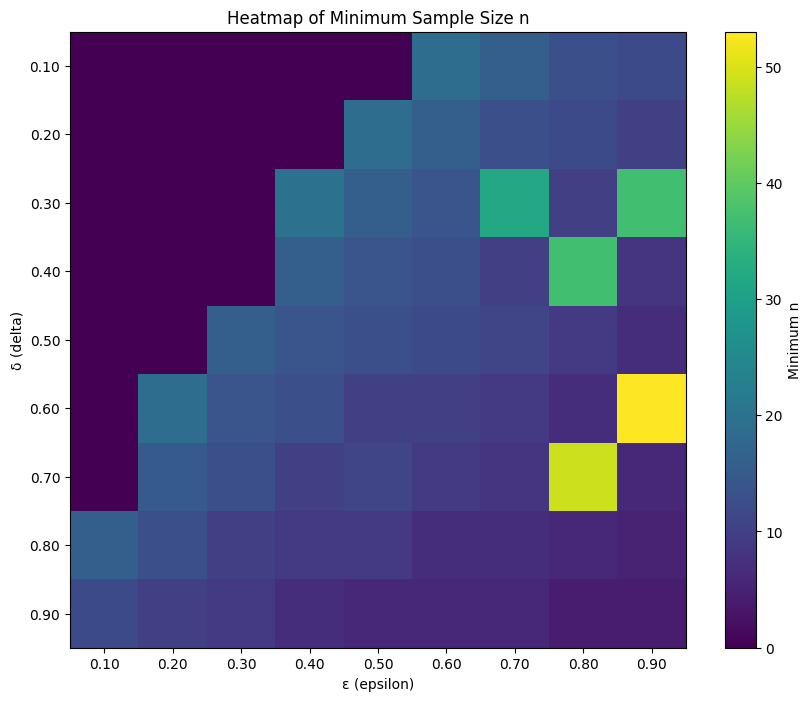

In [896]:
n5 = muck_with_d(n_samples, 5)
plot(n5)

###  Manhattan distance (L1 norm)

In [897]:
def distance(A, B):
    distance = np.sum(np.abs(A - B))
    return distance

## Plotting Distances

In [898]:
d_range = range(2, 13)

distances = [distance(n, muck_with_d(n_samples, d)) for d in d_range]

# Plotting
def plot_distance(d_range, distances):
    plt.figure(figsize=(10, 8))
    plt.plot(d_range, distances, marker='o', linestyle='-')
    plt.xlabel('Dimension (d)')
    plt.ylabel('Distance')
    plt.title('Distance as a Function of Dimension')
    plt.xticks(d_range)  # Ensure x-ticks correspond to the dimensions
    plt.grid(True)
    plt.show()

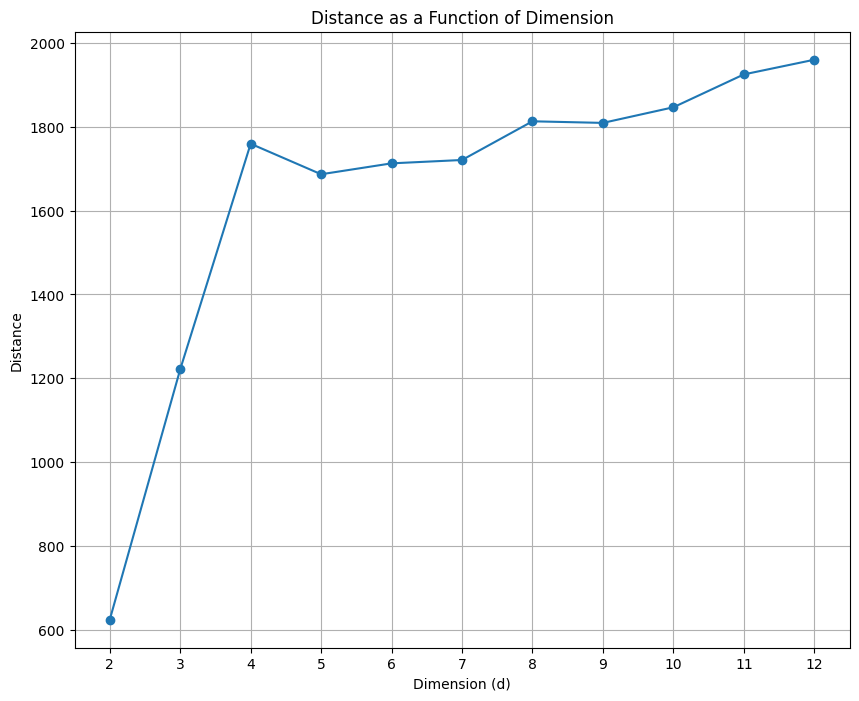

In [899]:
plot_distance(d_range, distances)

# Part 4: Muck With D

## Exponential D

## Triangular Distribution

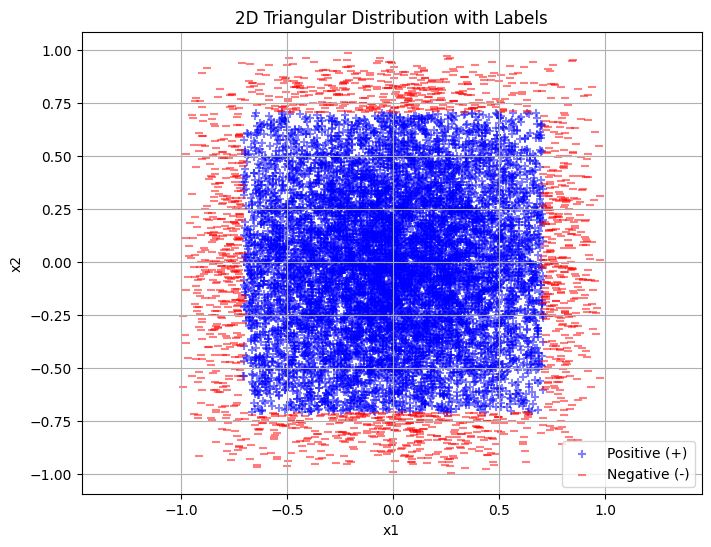

In [900]:
# Plotting Triangular Distribution for d = 2

x = np.random.triangular(-1, 0, 1, size=(10000, 2))
boundary = 1 / (2 ** (1/2))   # Calculate the boundary condition

y = label_within_hypercube(x, boundary)

plt.figure(figsize=(8, 6))

# Filter and plot points labeled as '+'
positive_points = x[y == '+']
plt.scatter(positive_points[:, 0], positive_points[:, 1], c='blue', marker='+', label='Positive (+)', alpha=0.5)

# Filter and plot points labeled as '-'
negative_points = x[y == '-']
plt.scatter(negative_points[:, 0], negative_points[:, 1], c='red', marker='_', label='Negative (-)', alpha=0.5)

# Additional plot formatting
plt.title('2D Triangular Distribution with Labels')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

In [901]:
def muck_with_d_triangular(n_samples, d):

    x = np.random.triangular(-1, 0, 1, size=(n_samples, d))

    boundary = 1 / (2 ** (1/d))   # Calculate the boundary condition

    y = label_within_hypercube(x, boundary)
    simulated_Ns = simulate_triangular(x, y)

    return simulated_Ns

In [902]:
import math

T = 200

def simulate_triangular(x, y):
    # calulate the volume of our labeling function f (sqrt(2) ^ d)
    curr_d = x.shape[1]     # current dimension
    f_volume = math.pow(2 ** 0.5, curr_d)
    simulated_Ns = np.zeros((9, 9))

    for n in range(150, 1, -1):
        generalization_errors = []
        for t in range(1, T+1, 1):
            # sample n points and calculate the generalization error (f_volume - h_volume) for each h selected by our algorithm
            indices = np.random.choice(x.shape[0], size=n, replace=True)     # Generate random unique indices for iid sampling from x
            x_sampled = x[indices]
            y_sampled = y[indices]
            min_coords, max_coords, h_volume = train_classifier(x_sampled, y_sampled)
            generalization_error = estimate_distribution_triangular(1000, curr_d, min_coords, max_coords)
            generalization_errors.append(generalization_error)
        for e in epsilon:
            generalization_errors_array = np.array(generalization_errors)
            errors_under_e = np.sum(np.abs(generalization_errors_array) < e)
            d = 1 - (errors_under_e / T)

            e_rounded = np.rint(e * 10).astype(int) - 1  # Round and convert to int
            d_rounded = np.rint(d * 10).astype(int) - 1



            if 0 <= e_rounded <= 8 and 0 <= d_rounded <= 8:     # get rid of extreme values
                index = (d_rounded, e_rounded)
                simulated_Ns[index] = n
                # print(f"Probability of sampling a set with n = {n}, error greater than {e} is: {d}")

            # plot n for curr_epsilon and curr_delta on our heatmap
    return simulated_Ns

In [903]:
def estimate_distribution_triangular(n_samples, d, min_coords, max_coords):

    points = np.random.triangular(-1, 0, 1, size=(n_samples, d))

    #Determine whether each point lies outside the smaller shape
    outside = np.any((points < min_coords) | (points > max_coords), axis=1)

    #Calculate the probability mass
    fraction_outside = np.sum(outside) / n_samples

    return fraction_outside

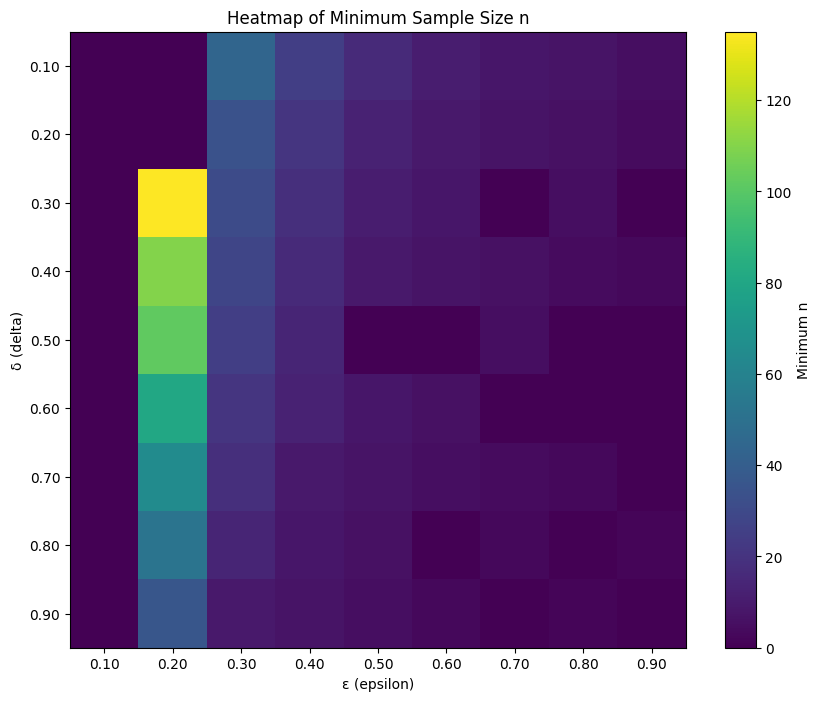

In [932]:
n__2 = muck_with_d_triangular(n_samples, 2)
plot(n__2)

In [905]:
distances = [distance(n, muck_with_d_triangular(n_samples, d)) for d in d_range]

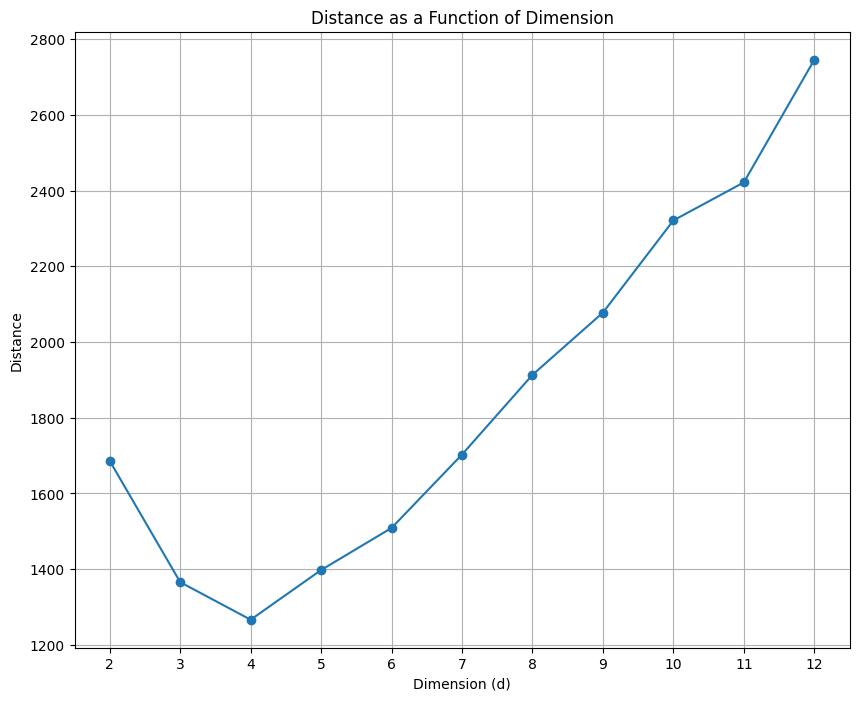

In [906]:
plot_distance(d_range, distances)

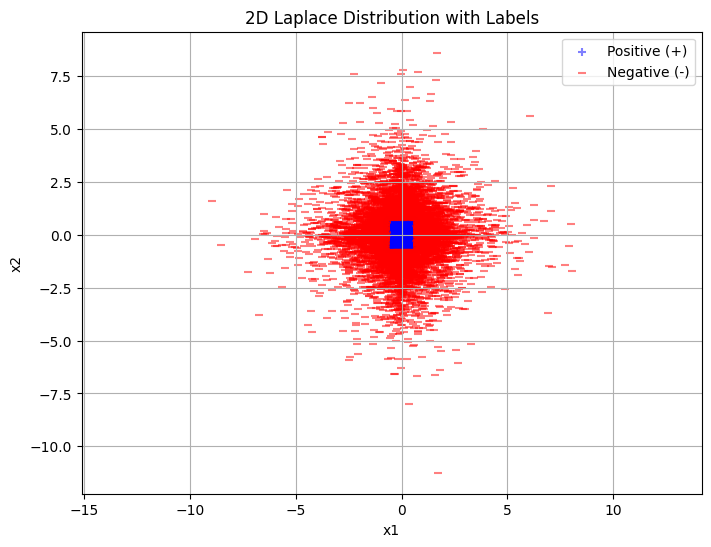

In [907]:
# Plotting Laplace Distribution for d = 2 (scale = 0.2)

from scipy.stats import laplace

x = np.random.laplace(loc=0, scale=1, size=(n_samples, 2))
boundary = 1 / (2 ** (1/2))   # Calculate the boundary condition

y = label_within_hypercube(x, boundary)

plt.figure(figsize=(8, 6))

# Filter and plot points labeled as '+'
positive_points = x[y == '+']
plt.scatter(positive_points[:, 0], positive_points[:, 1], c='blue', marker='+', label='Positive (+)', alpha=0.5)

# Filter and plot points labeled as '-'
negative_points = x[y == '-']
plt.scatter(negative_points[:, 0], negative_points[:, 1], c='red', marker='_', label='Negative (-)', alpha=0.5)

# Additional plot formatting
plt.title('2D Laplace Distribution with Labels')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()



In [923]:
def muck_with_d_laplace(n_samples, d):

    x = np.random.laplace(loc=0, scale=0.2, size=(n_samples, 2))

    boundary = 1 / (2 ** (1/d))   # Calculate the boundary condition

    y = label_within_hypercube(x, boundary)
    simulated_Ns = simulate_laplace(x, y)

    return simulated_Ns

In [922]:
import math

T = 200

def simulate_laplace(x, y):
    # calulate the volume of our labeling function f (sqrt(2) ^ d)
    curr_d = x.shape[1]     # current dimension
    f_volume = math.pow(2 ** 0.5, curr_d)
    simulated_Ns = np.zeros((9, 9))

    for n in range(150, 1, -1):
        generalization_errors = []
        for t in range(1, T+1, 1):
            # sample n points and calculate the generalization error (f_volume - h_volume) for each h selected by our algorithm
            indices = np.random.choice(x.shape[0], size=n, replace=True)     # Generate random unique indices for iid sampling from x
            x_sampled = x[indices]
            y_sampled = y[indices]
            min_coords, max_coords, h_volume = train_classifier(x_sampled, y_sampled)
            generalization_error = estimate_distribution_laplace(1000, curr_d, min_coords, max_coords)
            generalization_errors.append(generalization_error)
        for e in epsilon:
            generalization_errors_array = np.array(generalization_errors)
            errors_under_e = np.sum(np.abs(generalization_errors_array) < e)
            d = 1 - (errors_under_e / T)

            e_rounded = np.rint(e * 10).astype(int) - 1  # Round and convert to int
            d_rounded = np.rint(d * 10).astype(int) - 1



            if 0 <= e_rounded <= 8 and 0 <= d_rounded <= 8:     # get rid of extreme values
                index = (d_rounded, e_rounded)
                simulated_Ns[index] = n
                # print(f"Probability of sampling a set with n = {n}, error greater than {e} is: {d}")

            # plot n for curr_epsilon and curr_delta on our heatmap
    return simulated_Ns

In [928]:
def estimate_distribution_laplace(n_samples, d, min_coords, max_coords):

    points = np.random.laplace(loc=0, scale=0.2, size=(n_samples, 2))

    #Determine whether each point lies outside the smaller shape
    outside = np.any((points < min_coords) | (points > max_coords), axis=1)

    #Calculate the probability mass
    fraction_outside = np.sum(outside) / n_samples

    return fraction_outside

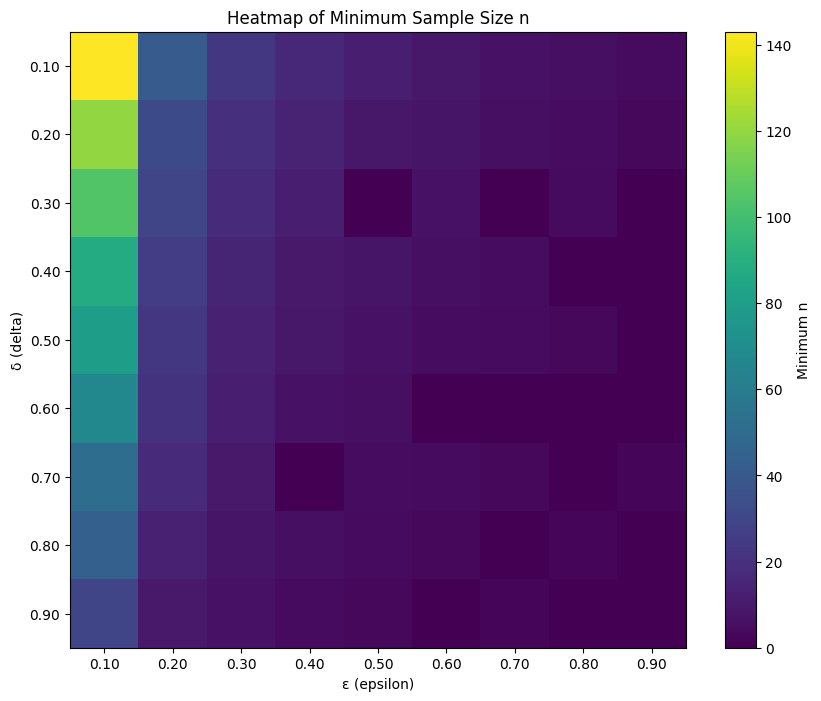

In [929]:
n___2 = muck_with_d_laplace(n_samples, 2)
plot(n___2)

In [912]:
distances = [distance(n, muck_with_d_triangular(n_samples, d)) for d in d_range]

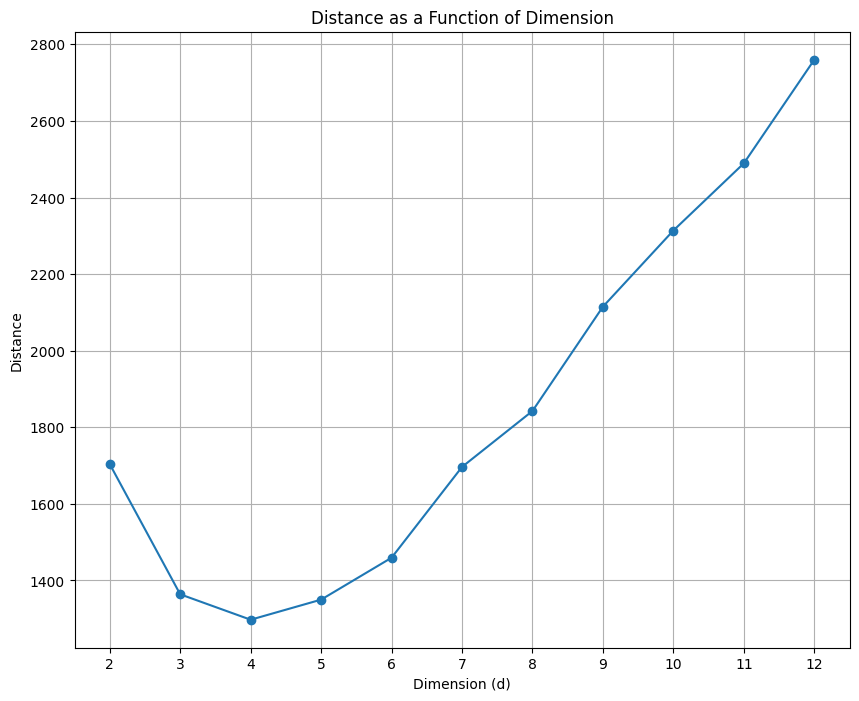

In [913]:
plot_distance(d_range, distances)

# Part 5: Go For Gold (Twice)

### Fixing d = 10, ε = 0.1, δ = 0.1 (can't do δ = 0.05 bc of how my classifier works)

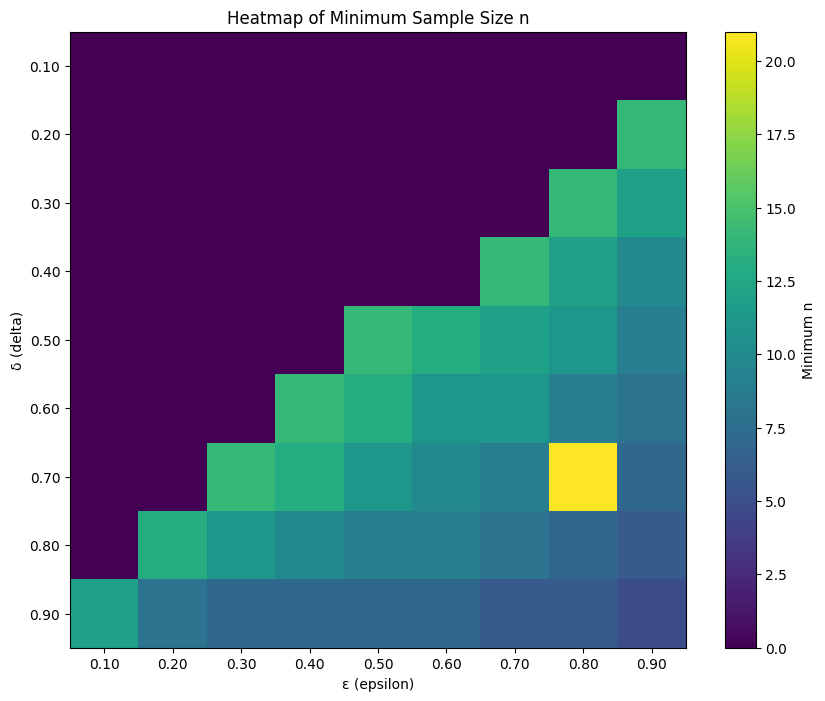

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0. 14. 12.]
 [ 0.  0.  0.  0.  0.  0. 14. 12. 10.]
 [ 0.  0.  0.  0. 14. 13. 12. 11.  9.]
 [ 0.  0.  0. 14. 13. 11. 11.  9.  8.]
 [ 0.  0. 14. 13. 11. 10.  9. 21.  7.]
 [ 0. 13. 11. 10.  9.  9.  8.  7.  6.]
 [12.  8.  7.  7.  7.  7.  6.  6.  5.]]


In [934]:
n_10 = muck_with_d(n_samples, 10)
plot(n_10)
print(n_10)

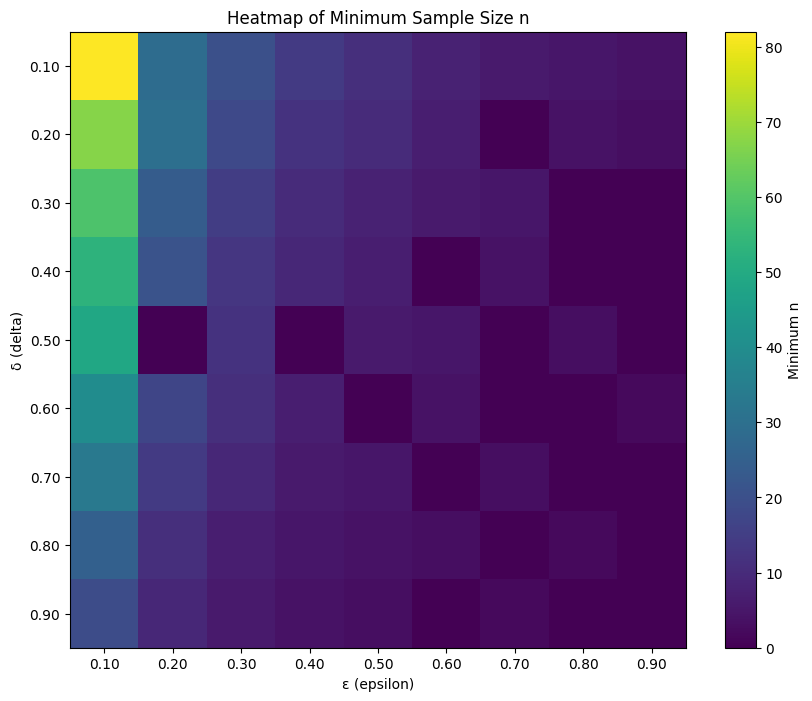

[[82. 29. 20. 14. 11.  8.  6.  5.  4.]
 [67. 30. 18. 12. 10.  7.  0.  4.  3.]
 [59. 24. 15. 10.  8.  6.  5.  0.  0.]
 [53. 21. 13.  9.  7.  0.  4.  0.  0.]
 [49.  0. 12.  0.  6.  5.  0.  3.  0.]
 [40. 17. 11.  7.  0.  4.  0.  0.  2.]
 [33. 14.  9.  6.  5.  0.  3.  0.  0.]
 [25. 11.  7.  5.  4.  3.  0.  2.  0.]
 [19.  9.  6.  4.  3.  0.  2.  0.  0.]]


In [930]:
n10 = muck_with_d_laplace(n_samples, 10)
plot(n10)
print(n10)

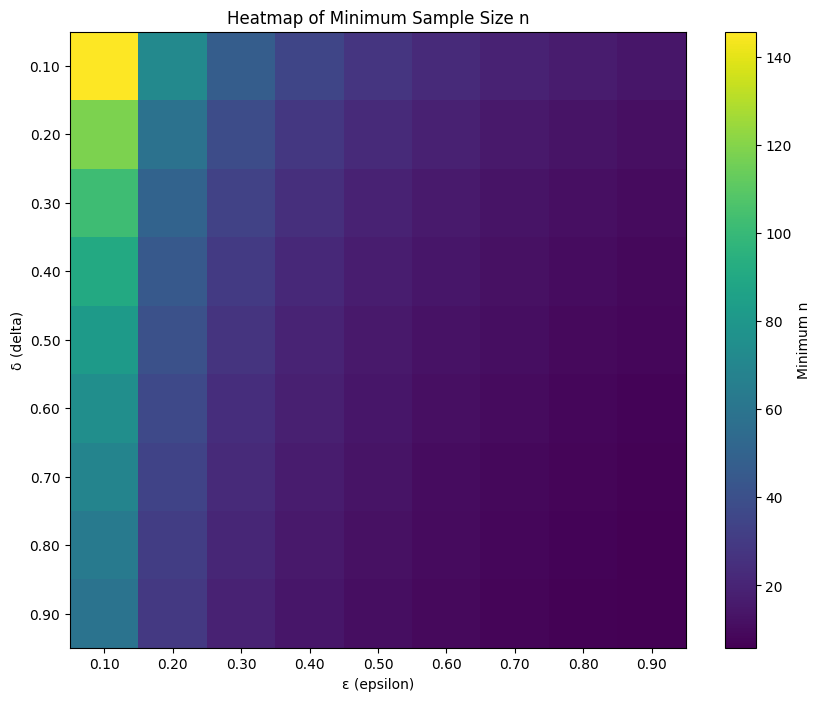

[[145.70295566  71.91738215  47.31665619  35.01197228  27.62555967
   22.69815255  19.17577149  16.5314186   14.47230922]
 [118.32510443  58.40397481  38.42577016  28.43315881  22.4346666
   18.43312827  15.57260904  13.42513488  11.75293591]
 [102.3100881   50.49913827  33.22493523  24.58479962  19.3981888
   15.938249    13.46489412  11.60807539  10.1622045 ]
 [ 90.94725319  44.89056748  29.53488412  21.85434533  17.24377353
   14.16810399  11.96944658  10.31885116   9.0335626 ]
 [ 82.1335537   40.540222    26.67265811  19.73644044  15.57267921
   12.79507285  10.80948736   9.31885116   8.15811993]
 [ 74.93223687  36.98573093  24.33404919  18.00598614  14.20729573
   11.67322472   9.86173166   8.50179167   7.44283119]
 [ 68.84361024  33.98045156  22.35678351  16.54290788  13.05288046
   10.72471564   9.06041564   7.81097771   6.83806317]
 [ 63.56940196  31.37716015  20.64399808  15.27553185  12.05288046
    9.90307971   8.36628413   7.21256744   6.31418929]
 [ 58.91722055  29.0808943

In [915]:
plot(n)
print(n)